토큰 인코딩: 토큰에 숫자를 부여  
토큰 임베딩: 토큰에 부여된 숫자에 의미를 부여

체크포인트: 트랜스포머 아키텍처로 로드되는 일련의 가중치

트랜스포머 모델을 훈련하는 전형적인 파이프라인
데이터셋(데이터셋 로드하고 전처리하기) -> 토크나이저(입력 텍스트를 토큰화하기) -> 트랜스포머스(모델을 로드, 훈련, 추론하기) -> 데이터셋 (측정 도구를 로드하고 모델을 평가하기)

# 2.1) 데이터셋
허깅 페이스 데이터셋 처음 사용하기

In [1]:
from datasets import list_datasets

all_datasets = list_datasets()
print(f"현재 허브에는 {len(all_datasets)}개의 데이터셋이 있습니다.")
print(f"처음 10개 데이터셋: {all_datasets[:10]}")

/home/jj/anaconda3/envs/deep/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_4474/3666915235.py:3: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  all_datasets = list_datasets()


현재 허브에는 46240개의 데이터셋이 있습니다.
처음 10개 데이터셋: ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


In [2]:
from datasets import load_dataset

# emotion 데이터셋이 다운로드되지 않으면 SetFit/emotion을 사용합니다.
emotions = load_dataset("emotion")

# emotions = load_dataset("emotion")을 emotions = load_datasets("SetFit/emotion")으로 수정할 경우
# SetFit/emotion의 label 특성은 ClassLabel 객체가 아닙니다. 수동으로 ClassLabel 객체를 만들어 주세요.
# from datasets import ClassLabel
# emotions['train'].features['label'] = ClassLabel(
# num_classes=6,
# names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])

No config specified, defaulting to: emotion/split
Found cached dataset emotion (/home/jj/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 415.39it/s]


In [3]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [4]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [5]:
len(train_ds)

16000

In [6]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [7]:
train_ds.column_names

['text', 'label']

In [8]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [9]:
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}


In [10]:
print(train_ds["text"][:5])

['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy']


### 데이터셋에서 데이터프레임으로

In [11]:
import pandas as pd

emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [12]:
emotions["train"].features['label'].__class__

datasets.features.features.ClassLabel

In [13]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


### 클래스 분포 살펴보기

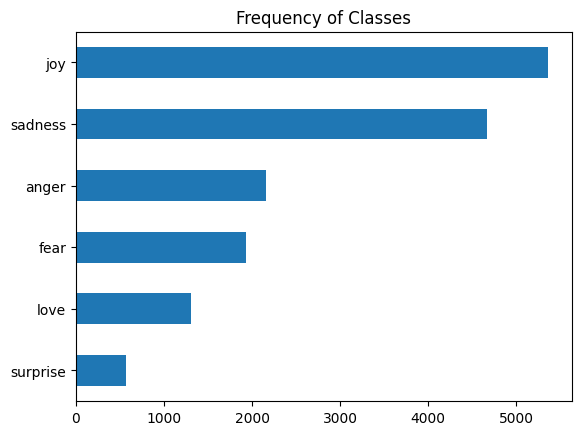

In [14]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

### 트윗 길이 확인

<Axes: title={'center': 'Words Per Tweet'}, xlabel='label_name'>

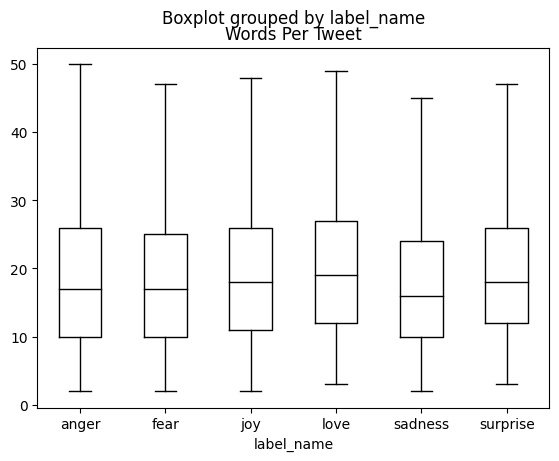

In [15]:
# 단어의 개수로 토큰의 수를 대략적으로 추정한다음
# 트윗당 단어 분포를 보고 감정에 따른 트윗 길이를 추정

df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False,
          showfliers=False, color="black")

그래프를 보면 각 감정의 트윗 길이는 15개 단어 정도임.
가장 긴 트윗도 DistilBERT의 최대 문맥 크기보다 더 작다 (DistilBERT의 최대 문맥 크기는 512 토큰임)

In [16]:
emotions.reset_format()

# 2.2) 텍스트에서 토큰으로

## 문자 토큰화

In [17]:
text = "Tokenizing text is a core task of NLP."
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P', '.']


모델은 각 문자가 정수로 변환되리라 기대한다.
이런 과정을 수치화 (numericalization)라고 한다.

In [18]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9, 'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18, 'z': 19}


In [19]:
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)
# print(len(input_ids)) # 38

[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7, 14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


In [20]:
import torch
import torch.nn.functional as F

input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))
one_hot_encodings.shape

torch.Size([38, 20])

In [21]:
print(f"토큰: {tokenized_text[0]}")
print(f"텐서 인덱스: {input_ids[0]}")
print(f"원-핫 인코딩: {one_hot_encodings[0]}")

토큰: T
텐서 인덱스: 5
원-핫 인코딩: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


## 문자 토큰화말고 단어 토큰화

In [22]:
# 구두점을 어떻게 처리할지
# great, greater, greatest는 모두 어간추출로 great로 만들 수 있다.
tokenized_text = text.split()
print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


## 단어 토큰화 말고 부분단어 토큰화

In [23]:
# AutoTokenizer 클래스는 체크포인트 이름을 사용해 모델의 설정, 사전 훈련된가중치, 어휘 사전을 자동으로 추출하는 '자동 클래스'다.

from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [24]:
# DistilBERT의 토크나이저를 로드
from transformers import DistilBertTokenizer

distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

In [25]:
encoded_text = tokenizer(text)
print(encoded_text)

# 문자 토큰화처럼 단어가 input_ids 필드에 있는 고유한 정수에 매핑됨.
# attention_mask 필드의 역할은 더 아래에서 소개

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [26]:
# input_ids가 있으므로 토크나이저의 convert_ids_to_tokens() 메서드를 사용해 이를 다시 토큰으로 변환할 수 있다.

tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


In [27]:
print(tokenizer.convert_tokens_to_string(tokens)) # 토큰들을 문자열로 합치는 메서드

[CLS] tokenizing text is a core task of nlp. [SEP]


In [28]:
tokenizer.vocab_size # 어휘사전의 크기

30522

In [29]:
tokenizer.model_max_length # 모델의 최대 문맥 크기

512

In [30]:
tokenizer.model_input_names # 모델이 forward pass에서 기대하는 필드 이름

['input_ids', 'attention_mask']

# 주의
사전 훈련된 모델을 사용할 때, 모델 훈련에 사용한 것과 동일한 토크나이저를 사용하는 것이 정말 중요하다.  
모델 입장에서 토크나이저를 바꾸는 것은 어휘사전을 뒤섞는 것이나 다름없음.  
주변 사람들이 'house'를 'cat'이라고 하는 등 마음대로 단어를 바꾼다면 도대체 무슨 일인지 상황을 이해하지 못할 것.

## 전체 데이터셋 토큰화하기

In [31]:
# padding=True로 하면 배치에 있는 가장 긴 샘플 크기에 맞춰 샘플을 0으로 패딩한다.
# truncation=True로 하면 모델의 최대 문맥 크기에 맞춰 샘플을 잘라낸다.
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [32]:
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


패딩결과 input_ids의 첫 번째 원소가 두 번째보다 더 짧으므로 길이를 동일하게 맞추기 위해 끝에 0을 추가.  
0은 어휘사전에 있는 [PAD] 토큰에 해당함.

In [33]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)
# input_ids와 attention_mask 열을 새로 추가한다.

Loading cached processed dataset at /home/jj/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-c87b4641db56a7ee.arrow
Loading cached processed dataset at /home/jj/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-4da02e6033454aa4.arrow
Loading cached processed dataset at /home/jj/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-627d96256725254a.arrow


In [34]:
print(emotions_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


# 2.3) 텍스트 분류 모델 훈련하기
특성추출 vs 미세 튜닝

## 트랜스포머를 특성 추출기로 사용하기
훈련하는 동안 바디의 가중치를 동결하고 은닉 상태를 분류 모델의 특성으로 사용

### 사전 훈련된 모델 사용하기

In [35]:
# from_pretrained() 이 메서드는 사전 훈련된 모델의 가중치를 로드한다.

from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### 마지막 은닉 상태 추출하기

In [36]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"입력 텐서 크기: {inputs['input_ids'].size()}")
# return_tensors="pt"를 안해주면 파이썬 리스트가 반환.
# 결과 텐서의 크기는 [batch_size, n_tokens]

입력 텐서 크기: torch.Size([1, 6])


In [37]:
inputs = {k:v.to(device) for k, v in inputs.items()}
with torch.no_grad(): # 그래디언트 자동 계산 비활성화
    outputs = model(**inputs)
print(outputs)
# 지금 모델은 마지막 은닉 상태 하나만 반환함.

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [38]:
# 이 은닉 상태의 크기를 확인 (마지막 은닉 상태 = 마지막 층의 은닉 상태)
# (모델을 호출할 때 output_hidden_states=True로 지정하면 전체 층의 은닉 상태를 얻는다.)
# 전체 층의 은닉 상태는 outputs 객체의 hidden_states 속성에 튜플로 저장되며 이 튜플의 마지막 원소가 last_hidden_state와 동일한 값이다.
outputs.last_hidden_state.size() # 6개의 입력토큰마다 768차원의 벡터가 반환됨

torch.Size([1, 6, 768])

분류작업에서는 보통 [CLS] 토큰에 연관된 은닉 상태를 입력 특성으로 사용.  
이 토큰은 시퀀스 시작에 등장하므로 다음처럼 outputs.last_hidden_state에 인덱스를 지정해 추출함.

In [39]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

#### 앞에서 수행한 작업들을 하나의 함수로 만들기.

In [40]:
def extract_hidden_states(batch):
    # 모델 입력을 GPU로 옮깁니다.
    inputs = {k:v.to(device) for k, v in batch.items()
             if k in tokenizer.model_input_names}
    # 마지막 은닉 상태를 추출합니다.
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # [CLS] 토큰에 대한 벡터를 반환합니다.
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [41]:
# 이 모델의 입력값은 텐서이므로 input_ids와 attention_mask 열을 "torch" 포맷으로 바꿉니다.
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])

In [42]:
# 그다음 모든 분할에 대해 은닉 상태를 한 번에 추출
# batch_size=None으로 지정하지 않았기 떄문에 디폴트인 batch_size=1000이 적용됨
# 기대한 대로 extract_hidden_states() 함수를 적용하면 새로운 hidden_state 열이 데이터셋에 추가됨.
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

In [43]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [44]:
emotions_hidden["train"]["hidden_state"]

tensor([[-0.1168,  0.0986, -0.1296,  ...,  0.0587,  0.3543,  0.4042],
        [-0.0324, -0.0323, -0.1957,  ..., -0.1747,  0.3546,  0.3028],
        [ 0.0397,  0.2022,  0.1423,  ..., -0.1141,  0.3394,  0.3958],
        ...,
        [-0.0034, -0.0959,  0.0584,  ..., -0.0427,  0.2496,  0.3076],
        [ 0.0666,  0.1733,  0.1290,  ...,  0.0612,  0.2904,  0.4684],
        [ 0.0167,  0.1013, -0.0073,  ..., -0.0649,  0.3454,  0.2199]])

#### 특성 행렬 만들기

In [45]:
# 은닉상태를 입력 특성으로 사용하고 레이블을 타깃으로 사용한다.
# 사이킷런 스타일로 잘 알려진 형식을 따라 해당 배열을 만들기.

import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
Y_train = np.array(emotions_hidden["train"]["label"])
Y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

#### 훈련 세트 시각화하기
768차원의 은닉 상태를 시각화하기는 어렵기 때문에 UMAP 알고리즘을 사용해서 이 벡터를 2D로 투영하겠습니다.  
UMAP은 특성이 [0,1]범위에 놓일 때 잘 동작한다. (따라서 MinMaxScaler를 적용하고 UMAP으로 구현하여 은닉 상태의 차원을 축소)

In [46]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# 특성 스케일을 [0, 1] 범위로 조정함.
X_scaled = MinMaxScaler().fit_transform(X_train)
# UMAP 객체를 생성하고 훈련합니다.
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# 2D 임베딩의 데이터프레임을 만듭니다.
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = Y_train
df_emb.head() # 특성이 768개에서 2개로 압축

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


,X,Y,label
0,4.438321,6.520364,0
1,-2.866280,5.892543,0
2,5.476390,2.992342,3
3,-2.081414,3.786861,2
4,-3.169922,3.841004,3


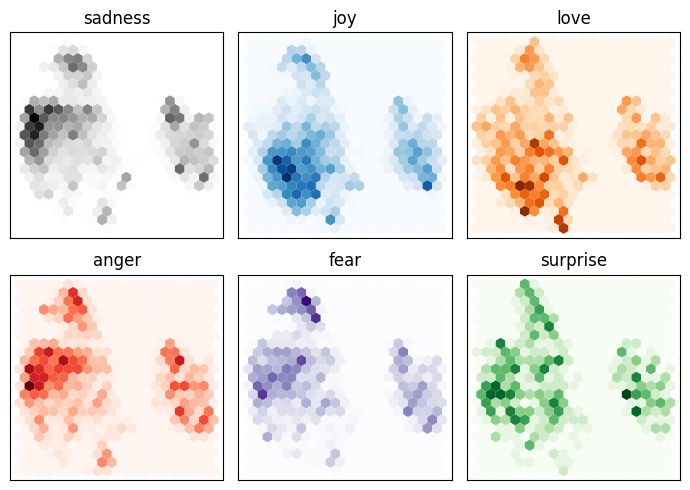

In [47]:
# 각 범주에 대한 샘플의 밀도를 개별로 그리기.

fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    #hexbin은 육각형의 고밀도 산점도 그래프
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                  gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([]) # set_xticks(), set_yticks()는 x축 y축 눈금이 어떻게 표시될지 범위 숫자 지정. ex) 0 20 40 60 80 100 -> 0 50 100

plt.tight_layout() # 여백에 관련된 서브플롯 파라미터를 조정
plt.show()

# 이 그림은 단지 저차원 공간으로 투영한 것임.
# 일부 범주가 중첩됐다고 원본 공간에서 분리할 수 없는 것은 아님.
# 이와 반대로 투영 공간에서 분리할 수 있다면 원본 공간에서도 분리할 수 있다.

In [48]:
labels

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [49]:
print(emotions["train"])
print("-----------------------------------------------")
print(emotions["train"].features)
print("-----------------------------------------------")
print(emotions["train"].features["label"])

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})
-----------------------------------------------
{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}
-----------------------------------------------
ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)


In [50]:
axes

array([<Axes: title={'center': 'sadness'}>,
       <Axes: title={'center': 'joy'}>, <Axes: title={'center': 'love'}>,
       <Axes: title={'center': 'anger'}>,
       <Axes: title={'center': 'fear'}>,
       <Axes: title={'center': 'surprise'}>], dtype=object)

#### 간단한 분류 모델 훈련하기

In [51]:
# 수렴을 보장하기 위해 'max_iter'를 증가시킨다.

from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, Y_train)

LogisticRegression(max_iter=3000)

In [52]:
lr_clf.score(X_valid, Y_valid)

0.6335

In [53]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent") # 가장 많이 등장하는 클래스만으로 예측하는 분류 모델
dummy_clf.fit(X_train, Y_train)
dummy_clf.score(X_valid, Y_valid)

0.352

불균형 클래스인데 가장 많이 등장하는 클래스만으로 예측할 때 보다 더 뛰어난 것을 확인할 수 있다.

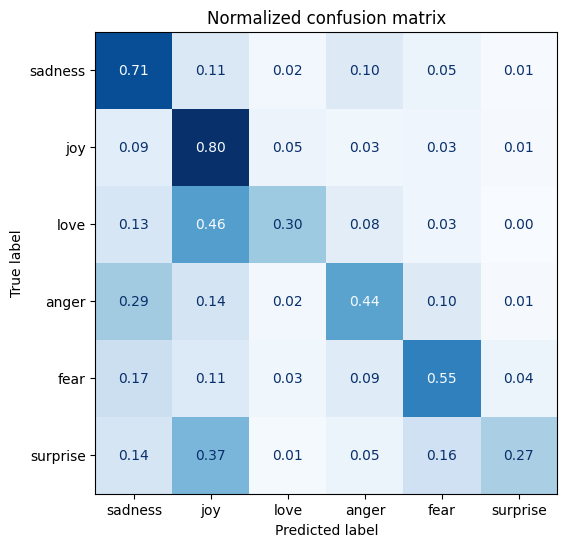

In [54]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, Y_valid, labels)

### 트랜스포머 미세 튜닝하기

트랜스포머를 엔드-투-엔드로 미세 튜닝  
미세 튜닝 방식에서는 은닉 상태를 고정된 특성으로 사용하지 않고 전체 모델을 훈련한다.  
이를 위해 분류 헤드는 미분 가능해야 한다. (backpropagation 하듯이)  
따라서 이 방식은 일반적으로 신경망으로 분류 작업을 수행한다.



#### 사전 훈련된 모델 로드하기

첫째로 필요한 요소는 특성 기반 방식에서 사용한 것과 같은 사전 훈련된 DistilBERT 모델이다.  
AutoModelForSequenceClassification이 AutoModel과 다른 점은 사전 훈련된 모델 출력 위에 base model(=사전 훈련된 DistilBERT모델)과 함께 쉽게 훈련할 수 있는 분류 헤드가 있음.  
분류 헤드의 출력 크기를 설정하기 위해 모델이 예측할 레이블 개수를 지정

In [55]:
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification
        .from_pretrained(model_ckpt, num_labels=num_labels)
        .to(device))

# 모델 일부가 랜덤하게 초기화된다는 경고를 볼 수 있음
# 분류헤드가 아직 훈련되지 않았으니, 이는 정상이다.

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'classifier.weight', 'pre_classifier.we

#### 성공 지표 정의하기

In [56]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted") #  average="weighted"는 클래스별 샘플 수에 따라 가중 평균화된 F1 점수를 반환
    acc = accuracy_score(labels, preds)
    return {"Accuracy" : acc, "f1": f1}

#### 모델 훈련하기

In [57]:
# from huggingface_hub import notebook_login

# notebook_login()

ImportError: The `notebook_login` function can only be used in a notebook (Jupyter or Colab) and you need the `ipywidgets` module: `pip install ipywidgets`.

In [58]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir = model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size = batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=logging_steps,
                                  push_to_hub=True,
                                  save_strategy="epoch",
                                  load_best_model_at_end=True,
                                  log_level="error",)
# 훈련이 끝난 후 최상의 모델을 자동으로 로드하려면 load_best_model_at_end 매개변수를 True로 설정하고 save_strategy 매개변수를 evaluation_strategy와 동일하게 맞춘다.

In [59]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

from transformers import Trainer

trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer,)
trainer.train();

/home/jj/github/NLP/distilbert-base-uncased-finetuned-emotion is already a clone of https://huggingface.co/bh8648/distilbert-base-uncased-finetuned-emotion. Make sure you pull the latest changes with `repo.git_pull()`.
/home/jj/anaconda3/envs/deep/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'eval_loss': 0.32075750827789307, 'eval_Accuracy': 0.904, 'eval_f1': 0.9016523491430191, 'eval_runtime': 2.6768, 'eval_samples_per_second': 747.167, 'eval_steps_per_second': 11.955, 'epoch': 1.0}
{'loss': 0.5467, 'learning_rate': 0.0, 'epoch': 2.0}
{'eval_loss': 0.22038845717906952, 'eval_Accuracy': 0.9265, 'eval_f1': 0.9264349572615436, 'eval_runtime': 3.9518, 'eval_samples_per_second': 506.1, 'eval_steps_per_second': 8.098, 'epoch': 2.0}
{'train_runtime': 162.2514, 'train_samples_per_second': 197.225, 'train_steps_per_second': 3.082, 'train_loss': 0.5466865844726563, 'epoch': 2.0}


In [60]:
preds_output = trainer.predict(emotions_encoded["validation"])
# predict 메서드의 출력은 PredictionOutput 객체로 predictions, label_ids 배열과 함께 Trainer 클래스에 전달한 측정 지표의 값도 담고 있다.

In [61]:
preds_output.metrics

{'test_loss': 0.22038845717906952,
 'test_Accuracy': 0.9265,
 'test_f1': 0.9264349572615436,
 'test_runtime': 2.787,
 'test_samples_per_second': 717.623,
 'test_steps_per_second': 11.482}

In [62]:
# 각 클래스에 대한 예측 데이터도 있음.
# np.argmax() 함수를 이용해 가장 큰 값이 나오도록 예측을 디코딩한다. -> 예측 레이블이 반환되며, 반환된 레이블은 특성 기반 방식에서 사이킷런 모델이 반환한 레이블과 포맷이 같다.
# 이걸로 오차행렬을 만듦
y_preds = np.argmax(preds_output.predictions, axis=1)

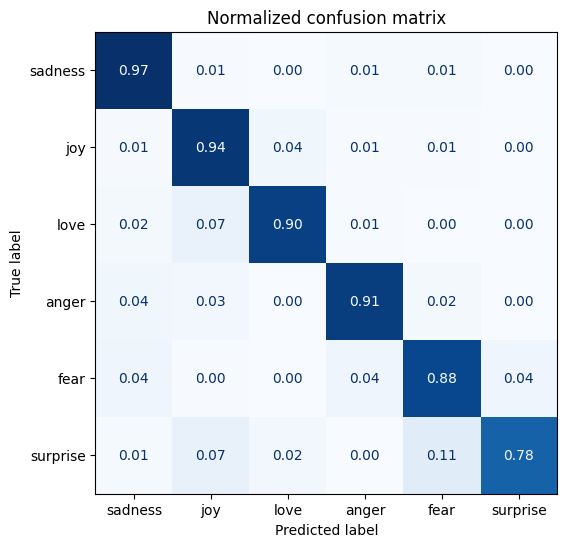

In [63]:
plot_confusion_matrix(y_preds, Y_valid, labels)

#### 오류분석

In [64]:
#손실과 예측 레이블을 반환하는 함수

from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # 모든 입력 텐서를 모델과 같은 장치로 이동
    inputs = {k:v.to(device) for k,v in batch.items()
             if k in tokenizer.model_input_names}
    
    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                            reduction="none")
        
    # 다른 데이터셋 열과 호환되도록 출력을 CPU로 옮김
    return {"loss": loss.cpu().numpy(),
           "predicted_label": pred_label.cpu().numpy()}

In [65]:
# 데이터셋을 다시 파이토치 텐서로 변환
emotions_encoded.set_format("torch",
                           columns=["input_ids", "attention_mask", "label"])

# 손실 값을 계산합니다.
emotions_encoded["validation"] = emotions_encoded["validation"].map(
                                forward_pass_with_label, batched=True, batch_size=16)

In [66]:
# 텍스트, 손실, 예측 레이블과 진짜 레이블로 DataFrame을 만든다.

emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

In [67]:
df_test

,text,label,predicted_label,loss
0,im feeling quite sad and sorry for myself but ...,sadness,sadness,0.026373
1,i feel like i am still looking at a blank canv...,sadness,sadness,0.025321
2,i feel like a faithful servant,love,love,0.284247
3,i am just feeling cranky and blue,anger,anger,0.033370
4,i can have for a treat or if i am feeling festive,joy,joy,0.017807
...,...,...,...,...
1995,im having ssa examination tomorrow in the morn...,sadness,sadness,0.027245
1996,i constantly worry about their fight against n...,joy,joy,0.020531
1997,i feel its important to share this info for th...,joy,joy,0.023113
1998,i truly feel that if you are passionate enough...,joy,joy,0.560464


### 이제 emotions_encoded를 손실 기준으로 오름차순이나 내림차순으로 정렬함.  
### 이 작업은 다음과 같은 사항을 감지한다.  
### 1) 잘못된 레이블  
데이터에 레이블을 부여하는 프로세스는 모두 완벽하지 않음.  
레이블을 부여하는 애너테이터(annotator)가 실수하거나 의견이 일치하지 않기도 함.  
또 다른 특성에서 추론된 레이블이 틀린 경우도 있다.  
데이터에 자동으로 레이블을 부여하기가 쉽다면 예측 모델이 필요하지 않으므로 잘못 레이블링된 샘플이 있는 것이 정상이다.  
앞에서와 같은 방식을 사용하면 이런 레이블을 빠르게 찾아 수정할 수 있다.
### 2) 데이터셋의 특이사항  
실세계의 데이터셋은 엉성하다.  
텍스트 데이터에서는 입력에 포함된 특수 문자나 문자열이 모델 예측에 큰 영향을 미치기도 한다.  
모델의 가장 나쁜 예측을 들여다보면 이런 특성을 찾게 되고, 데이터를 정제하거나 비슷한 샘플을 추가하면 모델이 안정된다.

In [68]:
# 손실이 가장 높은 샘플
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1950,i as representative of everything thats wrong ...,surprise,sadness,5.229831
1870,i guess i feel betrayed because i admired him ...,joy,sadness,5.229372
1963,i called myself pro life and voted for perry w...,joy,sadness,5.120049
1500,i guess we would naturally feel a sense of lon...,anger,sadness,5.104389
1274,i am going to several holiday parties and i ca...,joy,sadness,4.987124
882,i feel badly about reneging on my commitment t...,love,sadness,4.797879
1801,i feel that he was being overshadowed by the s...,love,sadness,4.777207
765,i feel super awkward and out of place right now,joy,sadness,4.515785
1111,im lazy my characters fall into categories of ...,joy,fear,4.271660
1840,id let you kill it now but as a matter of fact...,joy,fear,4.134989


### 딥러닝 모델은 예측을 얻기 위해 지름길을 찾고 활용하는 데 남다른 능력을 발휘한다.
### 이런 이유로, 시간이 걸리더라도 모델이 가장 강하게 확신하는 샘플을 조사하는 게 중요하다.

In [69]:
# 가장 손실이 낮은 샘플
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
1873,i feel practically virtuous this month i have ...,joy,joy,0.016905
1147,i type i feel bouncy and excited to get out my...,joy,joy,0.017012
19,i had lunch with an old friend and it was nice...,joy,joy,0.017056
1495,i got a lot of ideas and feel like the weekend...,joy,joy,0.017124
578,i got to christmas feeling positive about the ...,joy,joy,0.017240
1320,im feeling positive but its impossible to desc...,joy,joy,0.017314
1649,i feel relieved when she goes to bed because s...,joy,joy,0.017512
1548,im not feeling very festive this year,joy,joy,0.017526
632,i feel he is an terrific really worth bet,joy,joy,0.017559
1688,i feel very very rich and fulfilled and a part...,joy,joy,0.017666


이제 joy가 이따금 레이블링이 잘못되고 모델은 sadness 레이블을 예측하는 데 가장 강하게 확신한다는 사실을 알았다.  
훈련된 모델을 추론에 활용하기 전에 마지막 단계로 나중을 위해 모델을 저장해보자.

### 모델 저장 및 공유

In [70]:
trainer.push_to_hub(commit_message="Training completed!")

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.
Upload file pytorch_model.bin:   0%|                                                                       | 1.00/255M [00:00<?, ?B/s]
Upload file pytorch_model.bin: 259MB [00:53, 7.02MB/s]                                                                                To https://huggingface.co/bh8648/distilbert-base-uncased-finetuned-emotion
   945eea5..121cd28  main -> main

Upload file pytorch_model.bin: 100%|███████████████████████████████████████████████████████████████| 255M/255M [00:54<00:00, 4.95MB/s]

Upload file runs/Jul14_09-36-26_jj-System-Product-Name/events.out.tfevents.1689294991.jj-System-Product-Name.4474.0: 100%|█| 5.36k/5.3
Upload file runs/Jul14_09-36-26_jj-System-Product-Name/events.out.tfevents.1689294991.jj-System-Product-Name.4474.0: 100%|█| 5.36k/5.3
To https://huggingface.co/bh8648/distilbert-base-uncased-finetuned-emotion
   121cd28..875158f  main -> main



'https://huggingface.co/bh8648/distilbert-base-uncased-finetuned-emotion/commit/121cd28604a3073491ec7847ac1398a2f875bb82'

In [71]:
from transformers import pipeline

# 허브사용자이름/model
model_id = "bh8648/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)

In [72]:
custom_tweet = "I saw a movie today and it was really good. but tommorow, the final exam's score will be noticed. I'm really scarry"
preds = classifier(custom_tweet, return_all_scores=True)

/home/jj/anaconda3/envs/deep/lib/python3.9/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


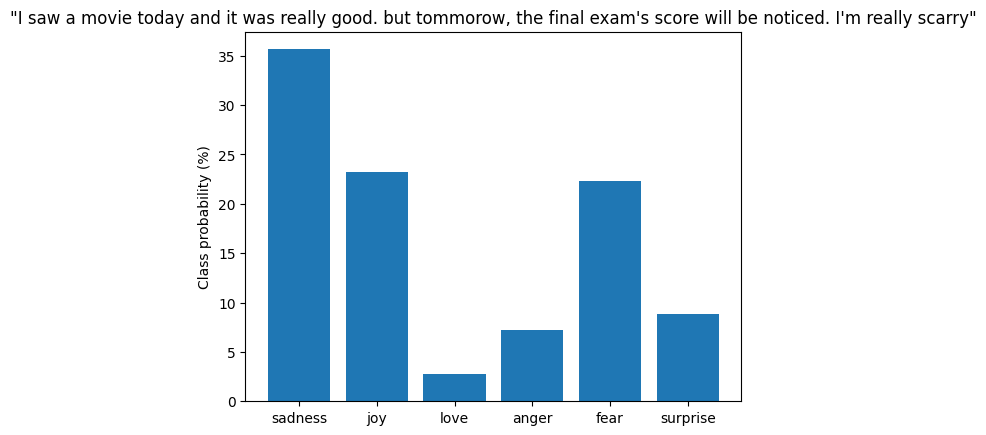

In [73]:
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100*preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()